# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/MyDrive/CS194-26/Final

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS194-26/Final


In [2]:
import torch
import numpy as np
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


In [3]:
def get_image(path):
  im = plt.imread(path)
  im = im.astype(float)
  return im

def show(im, figsize = 10, cmap=None):
  # Uses matplotlib in the backend to show images
  plt.figure(figsize=(figsize,figsize))
  plt.imshow(im, cmap=cmap)

In [4]:
def create_hooks(layers):
  hooks = []
  def return_output(self, input, output):
    hooks.append(output)
  for layer in layers:
    layer.register_forward_hook(return_output)
  return hooks


def content_loss(truth_activations, activations, weights = None):
  loss = 0
  for i, (truth_activation, activation) in enumerate(zip(truth_activations, activations)):
    loss += torch.mean((truth_activation - activation) ** 2) * (weights[i] if weights else 1)
  return loss


def style_loss(truth_activations, activations, weights = None):
  loss = 0
  for i, (truth_activation, activation) in enumerate(zip(truth_activations, activations)):
    truth_activation = truth_activation.squeeze(0).flatten(1,-1)  # Flatten into NxM
    N, M = truth_activation.shape
    activation = activation.squeeze(0).flatten(1,-1)  # Flatten into NxM, N is channels, M is H*W of feature map
    G_truth_activation = truth_activation @ truth_activation.T
    assert G_truth_activation.shape == (N, N)
    G_activation = activation @ activation.T
    loss += torch.mean((G_truth_activation - G_activation) ** 2) * (weights[i] if weights else 1)
  return loss


def optimize(model, img_tensor, style_img_tensor, content_img_tensor, style_layers, content_layers, optimizer, iterations=300, 
             constant_factors = [1, 1/1000], content_loss_fn = content_loss, style_loss_fn = style_loss,
             style_weights = None, content_weights = None, show_frequency = 50, device = torch.device('cpu')):
  
  """
  Here we take in 2 images, style_img_tensor, and content_img_tensor. We also take in an img_tensor
  which is the starting point for our optimization. We will
  first get our activations for each image, and then proceed to update the content
  image until we have an image that is good enough


  """

  assert len(style_layers) > 0 and len(content_layers) > 0

  # Create a normalization transformation since the network expects images normalized accordingly  
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

  # Create the hooks and keep the lists where our activations will show up
  style_activations = create_hooks(style_layers)
  content_activations = create_hooks(content_layers)

  # Get our initial activations we will compare to
  with torch.no_grad():
    # Get the style activations
    x = normalize(style_img_tensor)
    model(x)
    truth_style_activations = style_activations.copy()
    style_activations.clear()
    content_activations.clear()
    # Get the content activations
    x = normalize(content_img_tensor)
    model(x)
    truth_content_activations = content_activations.copy()
    style_activations.clear()
    content_activations.clear()


  outputs = []
  p_bar = tqdm(range(iterations))

  for iteration in p_bar:

    optimizer.zero_grad()

    x = normalize(img_tensor)
    model(x)
    assert len(style_activations) > 0 and len(content_activations) > 0
    style_loss = style_loss_fn(truth_style_activations, style_activations) * constant_factors[0]
    content_loss = content_loss_fn(truth_content_activations, content_activations) * constant_factors[1]
    loss = style_loss + content_loss
    style_loss = style_loss.detach().item()
    content_loss = content_loss.detach().item()

    loss.backward()
    optimizer.step()

    with torch.no_grad():
      img_tensor.clamp_(0, 1)
    
    style_activations.clear()
    content_activations.clear()

    outputs.append(img_tensor.detach().cpu())

    if (iteration % show_frequency) == 0:
      show(img_tensor.squeeze().detach().cpu().permute(1,2,0))
      print("Style Loss: ", style_loss, "Content Loss", content_loss)

    p_bar.set_postfix({'Style Loss': style_loss, 'Content Loss': content_loss})

  return img_tensor, outputs


In [5]:
model = torchvision.models.vgg19(pretrained = True).eval()

In [6]:
device = torch.device('cuda')
beautiful_world = get_image('beautiful_world.jpg')/255
content_tensor = torch.tensor(beautiful_world).permute(2,0,1).unsqueeze(0).float().to(device)

temple = get_image('monet.jpeg')/255
style_tensor = torch.tensor(temple).permute(2,0,1).unsqueeze(0).float()
style_tensor = transforms.Resize(beautiful_world.shape[:2])(style_tensor).to(device)

img_tensor = torch.randn(content_tensor.shape, device=device)/4 + .5 
img_tensor = torch.tensor(beautiful_world).permute(2,0,1).unsqueeze(0).float().to(device)
img_tensor.requires_grad = True

optimizer = torch.optim.Adam([img_tensor], lr = .004)

style_layers = [model.features[0], model.features[5], model.features[10]]#, model.features[19], model.features[28]]
content_layers = [model.features[19]]

img_tensor, outputs = optimize(model.features[:30].to(device), img_tensor, style_tensor, content_tensor, style_layers, content_layers, optimizer, 
                               constant_factors = [70, 8], iterations = 1000)

Output hidden; open in https://colab.research.google.com to view.

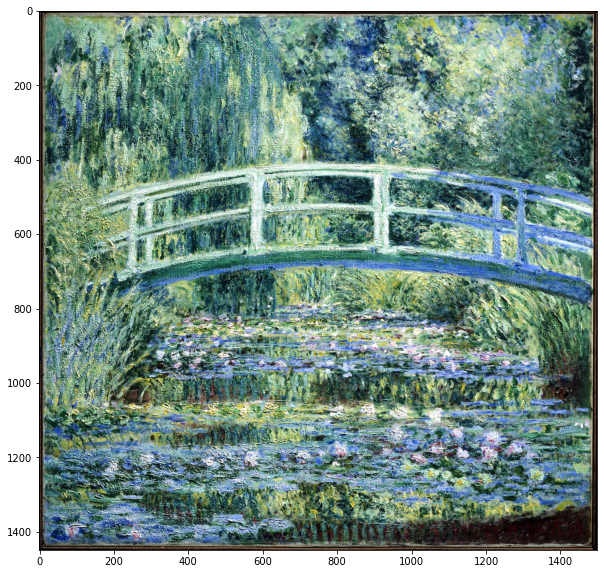

In [7]:
show(temple)

In [8]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd